<a href="https://colab.research.google.com/github/sathvika-vegiraju/svegira1_MachineLearning/blob/main/Assignment2/Assignment2_aml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# 0. Setup and imports

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks

# Reproducibility (best effort)
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow version:", tf.__version__)

# 1. Load IMDB data

# We'll use the Keras built-in IMDB dataset and vectorize as in-class example.
max_features = 10000
max_len = 500

(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=max_features)

# Pad sequences
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=max_len)
x_test  = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=max_len)

# Create a small validation fold from training set
val_frac = 0.2
val_size = int(len(x_train) * val_frac)
x_val = x_train[:val_size]
y_val = y_train[:val_size]
x_tr  = x_train[val_size:]
y_tr  = y_train[val_size:]

print("Train:", x_tr.shape, "Val:", x_val.shape, "Test:", x_test.shape)

# 2. Utility: build model factory
def make_net(input_shape,
             num_hidden_layers=2,
             units=32,
             activation='relu',
             loss='binary_crossentropy',
             use_dropout=False,
             dropout_rate=0.5,
             use_batchnorm=False,
             l2_lambda=0.0):
    inp = keras.Input(shape=input_shape, name='input_layer')
    x = layers.Embedding(max_features, 64, name='embed')(inp)
    x = layers.GlobalAveragePooling1D(name='gap')(x)

    # Hidden layers
    for i in range(num_hidden_layers):
        if l2_lambda > 0:
            reg = regularizers.l2(l2_lambda)
        else:
            reg = None
        x = layers.Dense(units, activation=activation, kernel_regularizer=reg, name=f'dense_{i+1}')(x)
        if use_batchnorm:
            x = layers.BatchNormalization(name=f'bn_{i+1}')(x)
        if use_dropout:
            x = layers.Dropout(dropout_rate, name=f'drop_{i+1}')(x)

    out = layers.Dense(1, activation='sigmoid', name='output')(x)
    model = keras.Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
    return model

# 3. Experiment grid
experiments = [
    # format: (label, params dict)
    ("base_2layers_relu_bce", dict(num_hidden_layers=2, units=32, activation='relu', loss='binary_crossentropy', use_dropout=False, use_batchnorm=False, l2_lambda=0.0)),
    ("one_layer_16", dict(num_hidden_layers=1, units=16, activation='relu', loss='binary_crossentropy')),
    ("three_layer_64", dict(num_hidden_layers=3, units=64, activation='relu', loss='binary_crossentropy', use_dropout=False)),
    ("units_32", dict(num_hidden_layers=2, units=32, activation='relu', loss='binary_crossentropy')),
    ("units_64", dict(num_hidden_layers=2, units=64, activation='relu', loss='binary_crossentropy')),
    ("mse_loss", dict(num_hidden_layers=2, units=32, activation='relu', loss='mse')),
    ("tanh_activation", dict(num_hidden_layers=2, units=32, activation='tanh', loss='binary_crossentropy')),
    ("dropout_0.5", dict(num_hidden_layers=2, units=32, activation='relu', loss='binary_crossentropy', use_dropout=True, dropout_rate=0.5)),
    ("l2_reg_1e-4", dict(num_hidden_layers=2, units=32, activation='relu', loss='binary_crossentropy', l2_lambda=1e-4)),
    ("batchnorm", dict(num_hidden_layers=2, units=32, activation='relu', loss='binary_crossentropy', use_batchnorm=True))
]


# 4. Training loop (runs each experiment)
results = []
save_dir = "imdb_experiments"
os.makedirs(save_dir, exist_ok=True)

for tag, params in experiments:
    print("\n\n*** Running:", tag, params)
    tf.keras.backend.clear_session()

    model = make_net((max_len,),
                     num_hidden_layers=params.get('num_hidden_layers', 2),
                     units=params.get('units', 32),
                     activation=params.get('activation', 'relu'),
                     loss=params.get('loss', 'binary_crossentropy'),
                     use_dropout=params.get('use_dropout', False),
                     dropout_rate=params.get('dropout_rate', 0.5),
                     use_batchnorm=params.get('use_batchnorm', False),
                     l2_lambda=params.get('l2_lambda', 0.0))

    # callbacks
    cb = [
        callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=0)
    ]

    history = model.fit(x_tr, y_tr,
                        epochs=20,
                        batch_size=512,
                        validation_data=(x_val, y_val),
                        callbacks=cb,
                        verbose=1)

    # Evaluate on validation and test
    val_loss, val_acc = model.evaluate(x_val, y_val, verbose=0)
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

    # Save history plot


    fig, ax = plt.subplots(1,2, figsize=(12,4))
    ax[0].plot(history.history['loss'], label='train_loss')
    ax[0].plot(history.history['val_loss'], label='val_loss')
    ax[0].set_title(f"{tag} loss")
    ax[0].legend()
    ax[1].plot(history.history['accuracy'], label='train_acc')
    ax[1].plot(history.history['val_accuracy'], label='val_acc')
    ax[1].set_title(f"{tag} accuracy")
    ax[1].legend()
    plt.tight_layout()
    figpath = os.path.join(save_dir, f"{tag}_history.png")
    fig.savefig(figpath)
    plt.close(fig)

    # Save model weights (optional)
    model.save(os.path.join(save_dir, f"{tag}_model.h5"))

    # Record results
    results.append({
        'experiment': tag,
        'params': params,
        'val_loss': float(val_loss),
        'val_acc': float(val_acc),
        'test_loss': float(test_loss),
        'test_acc': float(test_acc),
        'history_plot': figpath
    })

# 5. Results dataframe and save
df_results = pd.DataFrame(results)
df_results = df_results.sort_values('val_acc', ascending=False).reset_index(drop=True)
csv_path = os.path.join(save_dir, "experiment_summary.csv")
df_results.to_csv(csv_path, index=False)
print("Saved results to:", csv_path)
print(df_results[['experiment','val_acc','test_acc','val_loss','test_loss']])


TensorFlow version: 2.19.0
Train: (20000, 500) Val: (5000, 500) Test: (25000, 500)


*** Running: base_2layers_relu_bce {'num_hidden_layers': 2, 'units': 32, 'activation': 'relu', 'loss': 'binary_crossentropy', 'use_dropout': False, 'use_batchnorm': False, 'l2_lambda': 0.0}
Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - accuracy: 0.5141 - loss: 0.6920 - val_accuracy: 0.5344 - val_loss: 0.6900
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 179ms/step - accuracy: 0.5902 - loss: 0.6778 - val_accuracy: 0.5954 - val_loss: 0.6456
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.6874 - loss: 0.6110 - val_accuracy: 0.6684 - val_loss: 0.5728
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 0.7730 - loss: 0.4998 - val_accuracy: 0.7772 - val_loss: 0.4538
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 209ms/step - accuracy: 0.7922 - loss: 0.4352 - val_accuracy: 0.7848 - val_loss: 0.4299
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - accuracy: 0.8166 - loss: 0.39



*** Running: one_layer_16 {'num_hidden_layers': 1, 'units': 16, 'activation': 'relu', 'loss': 'binary_crossentropy'}
Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step - accuracy: 0.5264 - loss: 0.6900 - val_accuracy: 0.5602 - val_loss: 0.6782
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step - accuracy: 0.6155 - loss: 0.6667 - val_accuracy: 0.5862 - val_loss: 0.6479
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.6336 - loss: 0.6334 - val_accuracy: 0.6134 - val_loss: 0.6206
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step - accuracy: 0.7104 - loss: 0.5808 - val_accuracy: 0.7002 - val_loss: 0.5548
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.7891 - loss: 0.5139 - val_accuracy: 0.7632 - val_loss: 0.4922
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 0.8264 - loss: 0.4539 - val_accuracy: 0.8182 - val_loss: 0.4370
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 187ms/step - accuracy: 0.8470 - loss: 0.4053 - val_accuracy: 0.8138 - v



*** Running: three_layer_64 {'num_hidden_layers': 3, 'units': 64, 'activation': 'relu', 'loss': 'binary_crossentropy', 'use_dropout': False}
Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - accuracy: 0.5185 - loss: 0.6922 - val_accuracy: 0.5566 - val_loss: 0.6769
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.6229 - loss: 0.6534 - val_accuracy: 0.7210 - val_loss: 0.5528
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 178ms/step - accuracy: 0.7307 - loss: 0.5368 - val_accuracy: 0.6516 - val_loss: 0.6200
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - accuracy: 0.7349 - loss: 0.5269 - val_accuracy: 0.7468 - val_loss: 0.4706
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.7745 - loss: 0.4535 - val_accuracy: 0.8120 - val_loss: 0.3963
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 0.8384 - loss: 0.3623 - val_accuracy: 0.7688 - val_loss: 0.4543
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step - accuracy: 0.8265 - loss: 0.3735 -



*** Running: units_32 {'num_hidden_layers': 2, 'units': 32, 'activation': 'relu', 'loss': 'binary_crossentropy'}
Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - accuracy: 0.5069 - loss: 0.6924 - val_accuracy: 0.5260 - val_loss: 0.6930
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - accuracy: 0.5708 - loss: 0.6830 - val_accuracy: 0.5886 - val_loss: 0.6520
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.6814 - loss: 0.6193 - val_accuracy: 0.6576 - val_loss: 0.5852
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - accuracy: 0.7672 - loss: 0.5080 - val_accuracy: 0.7736 - val_loss: 0.4591
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.7891 - loss: 0.4388 - val_accuracy: 0.7824 - val_loss: 0.4337
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 180ms/step - accuracy: 0.8136 - loss: 0.3981 - val_accuracy: 0.8492 - val_loss: 0.3680
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.8575 - loss: 0.3430 - val_accuracy: 0.8418 - val_l



*** Running: units_64 {'num_hidden_layers': 2, 'units': 64, 'activation': 'relu', 'loss': 'binary_crossentropy'}
Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 181ms/step - accuracy: 0.5194 - loss: 0.6906 - val_accuracy: 0.5496 - val_loss: 0.6755
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.6269 - loss: 0.6466 - val_accuracy: 0.6108 - val_loss: 0.6361
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - accuracy: 0.7055 - loss: 0.5474 - val_accuracy: 0.7508 - val_loss: 0.4783
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.7879 - loss: 0.4418 - val_accuracy: 0.7158 - val_loss: 0.5206
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - accuracy: 0.7601 - loss: 0.4745 - val_accuracy: 0.8416 - val_loss: 0.3755
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 172ms/step - accuracy: 0.8456 - loss: 0.3611 - val_accuracy: 0.8638 - val_loss: 0.3427
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 0.8726 - loss: 0.3161 - val_accuracy: 0.8274 - val_l



*** Running: mse_loss {'num_hidden_layers': 2, 'units': 32, 'activation': 'relu', 'loss': 'mse'}
Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step - accuracy: 0.5258 - loss: 0.2495 - val_accuracy: 0.5350 - val_loss: 0.2476
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.6001 - loss: 0.2422 - val_accuracy: 0.5756 - val_loss: 0.2328
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - accuracy: 0.6741 - loss: 0.2151 - val_accuracy: 0.6584 - val_loss: 0.2027
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - accuracy: 0.7604 - loss: 0.1702 - val_accuracy: 0.6458 - val_loss: 0.2203
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.7645 - loss: 0.1585 - val_accuracy: 0.7874 - val_loss: 0.1416
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 179ms/step - accuracy: 0.7545 - loss: 0.1669 - val_accuracy: 0.7134 - val_loss: 0.1793
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - accuracy: 0.8261 - loss: 0.1263 - val_accuracy: 0.7832 - val_loss: 0.1389
Ep



*** Running: tanh_activation {'num_hidden_layers': 2, 'units': 32, 'activation': 'tanh', 'loss': 'binary_crossentropy'}
Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - accuracy: 0.5344 - loss: 0.6887 - val_accuracy: 0.5644 - val_loss: 0.6667
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - accuracy: 0.6341 - loss: 0.6270 - val_accuracy: 0.7052 - val_loss: 0.5376
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.7078 - loss: 0.5451 - val_accuracy: 0.8282 - val_loss: 0.4568
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 165ms/step - accuracy: 0.8173 - loss: 0.4360 - val_accuracy: 0.8132 - val_loss: 0.4145
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.8449 - loss: 0.3734 - val_accuracy: 0.8486 - val_loss: 0.3627
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.8361 - loss: 0.3605 - val_accuracy: 0.8642 - val_loss: 0.3420
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - accuracy: 0.8719 - loss: 0.3131 - val_accuracy: 0.8102 



*** Running: dropout_0.5 {'num_hidden_layers': 2, 'units': 32, 'activation': 'relu', 'loss': 'binary_crossentropy', 'use_dropout': True, 'dropout_rate': 0.5}
Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 180ms/step - accuracy: 0.5060 - loss: 0.6937 - val_accuracy: 0.5362 - val_loss: 0.6916
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.5257 - loss: 0.6916 - val_accuracy: 0.5384 - val_loss: 0.6885
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 0.5672 - loss: 0.6837 - val_accuracy: 0.5566 - val_loss: 0.6730
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 179ms/step - accuracy: 0.5923 - loss: 0.6735 - val_accuracy: 0.7148 - val_loss: 0.6013
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - accuracy: 0.7040 - loss: 0.5906 - val_accuracy: 0.6974 - val_loss: 0.5500
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - accuracy: 0.7532 - loss: 0.5218 - val_accuracy: 0.7982 - val_loss: 0.4861
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - accuracy: 0.7905



*** Running: l2_reg_1e-4 {'num_hidden_layers': 2, 'units': 32, 'activation': 'relu', 'loss': 'binary_crossentropy', 'l2_lambda': 0.0001}
Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - accuracy: 0.5256 - loss: 0.6994 - val_accuracy: 0.5244 - val_loss: 0.6957
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - accuracy: 0.5941 - loss: 0.6885 - val_accuracy: 0.5650 - val_loss: 0.6734
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 175ms/step - accuracy: 0.6309 - loss: 0.6494 - val_accuracy: 0.6722 - val_loss: 0.5958
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.7433 - loss: 0.5510 - val_accuracy: 0.7484 - val_loss: 0.5001
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 179ms/step - accuracy: 0.8169 - loss: 0.4474 - val_accuracy: 0.8140 - val_loss: 0.4195
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 199ms/step - accuracy: 0.8225 - loss: 0.4020 - val_accuracy: 0.7984 - val_loss: 0.4162
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.8234 - loss: 0.3899 - va



*** Running: batchnorm {'num_hidden_layers': 2, 'units': 32, 'activation': 'relu', 'loss': 'binary_crossentropy', 'use_batchnorm': True}
Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - accuracy: 0.6984 - loss: 0.5668 - val_accuracy: 0.5096 - val_loss: 0.6880
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.8979 - loss: 0.2701 - val_accuracy: 0.5094 - val_loss: 0.6824
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 158ms/step - accuracy: 0.9305 - loss: 0.1939 - val_accuracy: 0.6990 - val_loss: 0.6731
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 191ms/step - accuracy: 0.9498 - loss: 0.1477 - val_accuracy: 0.8084 - val_loss: 0.6614
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 0.9570 - loss: 0.1295 - val_accuracy: 0.6814 - val_loss: 0.6470
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step - accuracy: 0.9598 - loss: 0.1426 - val_accuracy: 0.7984 - val_loss: 0.6017
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.9734 - loss: 0.0917 - val

Saved results to: imdb_experiments/experiment_summary.csv
              experiment  val_acc  test_acc  val_loss  test_loss
0         three_layer_64   0.8928   0.88452  0.279500   0.287951
1               units_64   0.8900   0.88284  0.287217   0.294464
2               units_32   0.8894   0.88244  0.287730   0.295285
3        tanh_activation   0.8884   0.88280  0.292533   0.299948
4  base_2layers_relu_bce   0.8878   0.88112  0.290926   0.298456
5               mse_loss   0.8834   0.87856  0.088955   0.091633
6           one_layer_16   0.8800   0.87500  0.294364   0.301354
7            dropout_0.5   0.8794   0.87164  0.305695   0.314777
8            l2_reg_1e-4   0.8620   0.85976  0.342717   0.345819
9              batchnorm   0.8586   0.83680  0.337412   0.374806


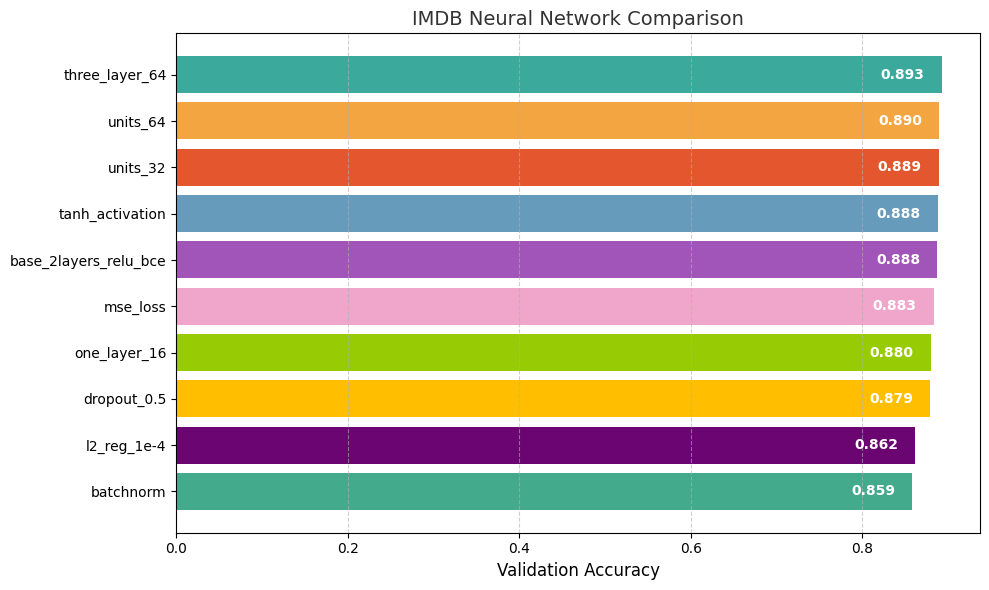

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("imdb_experiments/experiment_summary.csv")

plt.figure(figsize=(10, 6))
bars = plt.barh(df['experiment'], df['val_acc'], color=['#3BA99C','#F2A541','#E4572E','#669BBC','#A155B9','#F0A6CA','#97CC04','#FFBF00','#6A0572','#43AA8B'])
plt.xlabel('Validation Accuracy', fontsize=12)
plt.title('IMDB Neural Network Comparison', fontsize=14, color='#333333')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.gca().invert_yaxis()

for bar in bars:
    plt.text(bar.get_width() - 0.02, bar.get_y() + bar.get_height()/2, f"{bar.get_width():.3f}",
             ha='right', va='center', fontsize=10, color='white', fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
import os
save_dir = "imdb_experiments"
os.makedirs(save_dir, exist_ok=True)
print("Folder created:", os.path.abspath(save_dir))


Folder created: /content/imdb_experiments


In [ ]:
!ls -lh imdb_experiments


total 75M
-rw-r--r-- 1 root root  49K Oct 12 23:20 base_2layers_relu_bce_history.png
-rw-r--r-- 1 root root 7.4M Oct 12 23:20 base_2layers_relu_bce_model.h5
-rw-r--r-- 1 root root  50K Oct 12 23:40 batchnorm_history.png
-rw-r--r-- 1 root root 7.5M Oct 12 23:40 batchnorm_model.h5
-rw-r--r-- 1 root root  65K Oct 12 23:36 dropout_0.5_history.png
-rw-r--r-- 1 root root 7.4M Oct 12 23:36 dropout_0.5_model.h5
-rw-r--r-- 1 root root 2.4K Oct 12 23:40 experiment_summary.csv
-rw-r--r-- 1 root root  50K Oct 12 23:38 l2_reg_1e-4_history.png
-rw-r--r-- 1 root root 7.4M Oct 12 23:38 l2_reg_1e-4_model.h5
-rw-r--r-- 1 root root  61K Oct 12 23:32 mse_loss_history.png
-rw-r--r-- 1 root root 7.4M Oct 12 23:32 mse_loss_model.h5
-rw-r--r-- 1 root root  48K Oct 12 23:22 one_layer_16_history.png
-rw-r--r-- 1 root root 7.4M Oct 12 23:22 one_layer_16_model.h5
-rw-r--r-- 1 root root  63K Oct 12 23:34 tanh_activation_history.png
-rw-r--r-- 1 root root 7.4M Oct 12 23:34 tanh_activation_model.h5
-rw-r--r-- 1 root